In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import gensim
import gensim.downloader as api
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import tokenize
from spacy.tokens.doc import Doc
from spacy.vocab import Vocab
import spacy
from spacy.language import Language
from spacy.matcher import Matcher
from spacy import displacy
import json

In [2]:
#examples for testing
default_category = "Trades & Services"
default_city = "Sydney"

In [3]:
df = pd.read_csv("seek_australia.csv", encoding='utf8')

In [4]:
df

,category,city,company_name,geo,job_board,job_description,job_title,job_type,post_date,salary_offered,state,url
0,Retail & Consumer Products,Sydney,Frontline Executive Retail Sydney,AU,seek,Have you had 10 years experience in fresh pro...,Store Manager - Fresh Produce,Full Time,2018-04-15T23:13:45Z,$100k Base + Super + Benefits,North Shore & Northern Beaches,https://www.seek.com.au/job/35989382
1,Government & Defence,Brisbane,Powerlink,AU,seek,The Opportunity: The Client Solution Analyst ...,Client Solution Analyst,Full Time,2018-04-15T23:04:40Z,Excellent remuneration packages,Northern Suburbs,https://www.seek.com.au/job/35989272
2,Trades & Services,Sydney,Richard Jay Laundry,AU,seek,An innovative business development role for a...,Service Technician / Installer - NSW,Full Time,2018-04-15T23:04:31Z,NaN,Parramatta & Western Suburbs,https://www.seek.com.au/job/35989270
3,Trades & Services,Melbourne,Adaptalift Hyster,AU,seek,About the role: We are seeking an Automotive W...,Workshop Technician I Material Handling Equipment,Full Time,2018-04-16T03:15:17Z,NaN,Bayside & South Eastern Suburbs,https://www.seek.com.au/job/35993203
4,Trades & Services,Adelaide,Bakers Delight G&M,AU,seek,Â Early starts and weekend shifts. No experie...,APPRENTICESHIP JUNIOR BAKER,Full Time,2018-04-16T01:26:50Z,NaN,NaN,https://www.seek.com.au/job/35991578
...,...,...,...,...,...,...,...,...,...,...,...,...
29995,Hospitality & Tourism,Sydney,Radisson Blu Plaza Hotel Sydney,AU,seek,Hotel snapshot The Radisson Blu Plaza Sydney ...,Bar Supervisor,Full Time,2018-04-11T04:20:40Z,"Annualised salary, uniform + Super","CBD, Inner West & Eastern Suburbs",https://www.seek.com.au/job/35958503
29996,CEO & General Management,ACT,Airservices Australia,AU,seek,The Organisation Airservices is a government ...,Deputy Board Secretary,Full Time,2018-04-11T04:00:49Z,Salary package to be negotiated,NaN,https://www.seek.com.au/job/35958100
29997,Accounting,Melbourne,The Hassett Group,AU,seek,ABOUT THE COMPANY AND ROLE Our client is one o...,Corporate Accountant,Full Time,2018-04-11T02:45:37Z,$110k Package On Offer!,CBD & Inner Suburbs,https://www.seek.com.au/job/35956991
29998,Government & Defence,ACT,SOS Recruitment,AU,seek,Long term contract for 12 months with possibl...,APS 6 & EL1 Account Managers,Contract/Temp,2018-04-11T04:55:16Z,NaN,NaN,https://www.seek.com.au/job/35959184


In [7]:
df["job_description"][0]

' Have you had 10 years experience in fresh produce that wants to manage their own store for a family owned Australian company that is passionate about food. We are looking for: Must have 10+ years in the fresh food business and have the passion for the role. Current 2IC looking to progress with training into Store manager role. Excellent customer service and communication skills Be hands on and have a can do attitude Be into the fresh food business and have the passion for the role Hardworking, ambitious and competitive people who are passionate about good food. Are able to maximise the financial return in their market, ensuring it meets sales, margin and wages budgets. Have exceptional merchandising capabilities and customer service skills helping us to create unique shopping experiences for our customers. Have a wealth of knowledge of fresh food retailing and a willingness to share this knowledge. Can lead, manage and motivate a teams. Must be able to work weekend and use to early s

# Data Exploration

In [5]:
df["category"].unique()

array(['Retail & Consumer Products', 'Government & Defence',
       'Trades & Services', 'Manufacturing, Transport & Logistics',
       'Sales', 'Community Services & Development',
       'Healthcare & Medical', 'Information & Communication Technology',
       'Mining, Resources & Energy', 'Construction',
       'Design & Architecture', 'Call Centre & Customer Service',
       'Marketing & Communications', 'Administration & Office Support',
       'Banking & Financial Services', 'Engineering',
       'Education & Training', 'Accounting',
       'Human Resources & Recruitment', 'Real Estate & Property',
       'Sport & Recreation', 'Legal', 'Hospitality & Tourism',
       'Consulting & Strategy', 'Farming, Animals & Conservation',
       'Advertising, Arts & Media', 'Insurance & Superannuation',
       'Self Employment', 'CEO & General Management',
       'Science & Technology'], dtype=object)

In [6]:
df.describe()

,category,city,company_name,geo,job_board,job_description,job_title,job_type,post_date,salary_offered,state,url
count,30000,30000,30000,30000,30000,29655,30000,30000,30000,8952,19180,30000
unique,30,65,9054,1,1,26850,20979,4,24747,5373,19,30000
top,Trades & Services,Sydney,Private Advertiser,AU,seek,Today we have around 250 people who work to h...,Business Development Manager,Full Time,2018-04-16T09:29:00Z,"$100,502 - $114,624",CBD & Inner Suburbs,https://www.seek.com.au/job/35874202
freq,3346,9412,1491,30000,30000,101,122,20203,14,130,4690,1


In [188]:
def category_frequency(city=default_city):
    """returns a dictionary of the form category: count for a given city"""
    return dict(df[df["city"] == city]["category"].value_counts())

def visualise_categories(data, city):
    """Plots the frequecy of categories for a given city"""
    names = list(data.keys())
    values = list(data.values())
    plt.figure(figsize=(12,10))
    plt.bar(range(len(data)), values, tick_label=names)
    plt.ylabel("Count")
    plt.title(f"Categories for {city}")
    plt.xticks(rotation=90)
    plt.show()
    
def unique_categories(city=default_city):
    """prints the number of unique categories for a given city"""
    print(f"Number of unique categories for {city}: {len(category_frequency(city=city))}")

In [187]:
for city in df["city"].unique():
    unique_categories(city)

Number of unique categories for Sydney: 30
Number of unique categories for Brisbane: 30
Number of unique categories for Melbourne: 30
Number of unique categories for Adelaide: 29
Number of unique categories for Northam & Wheatbelt: 13
Number of unique categories for Port Hedland, Karratha & Pilbara: 19
Number of unique categories for Gosford & Central Coast: 23
Number of unique categories for Newcastle, Maitland & Hunter: 28
Number of unique categories for Gold Coast: 26
Number of unique categories for Rockhampton & Capricorn Coast: 17
Number of unique categories for Wollongong, Illawarra & South Coast: 25
Number of unique categories for Blue Mountains & Central West: 22
Number of unique categories for Kalgoorlie, Goldfields & Esperance: 17
Number of unique categories for Dubbo & Central NSW: 17
Number of unique categories for Cairns & Far North: 25
Number of unique categories for Perth: 30
Number of unique categories for Bunbury & South West: 19
Number of unique categories for Hobart:

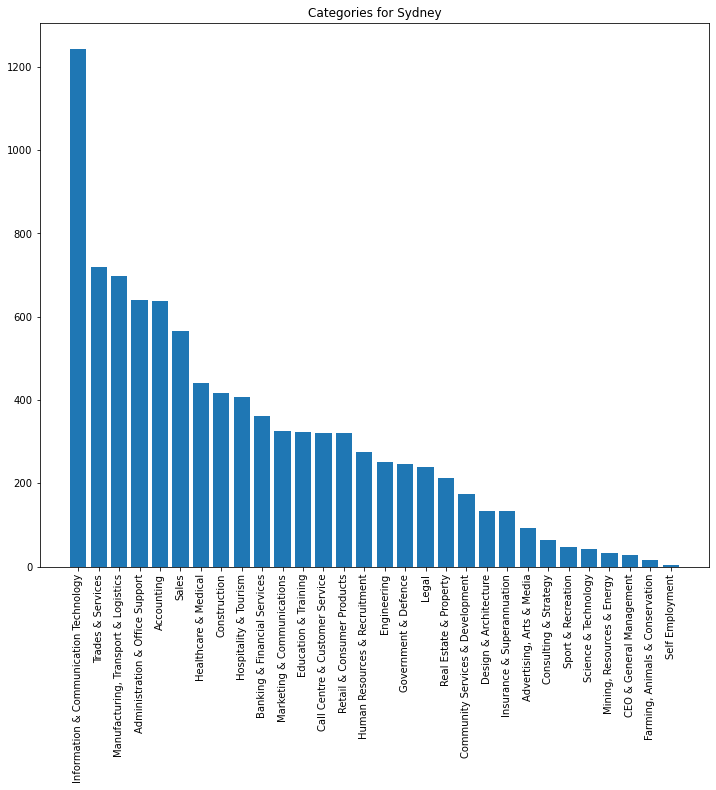

In [8]:
visualise_categories(unique_categories(city="Sydney"), "Sydney")

In [9]:
def sanitize(data):
    """
    removes the Â and \xa0 characters that can sometimes be present in unicode input
    """
    return data.apply(lambda x: str(x).encode("ascii", "ignore").decode())

In [10]:
def category_data(category=default_category, concat=False):
    """
    returns call the relevant job descriptions for a given category
        Parameters:
            category (str): category to get descriptions for
            concat (bool): whether to concatenate all job descriptions into a single string
        returns:
            Either list of job descriptions or a single string 
            of all job descriptions
    """
    descriptions = df[df["category"]==category]["job_description"]
    space_sanitized = sanitize(descriptions)
    if concat:
        return space_sanitized.str.cat(sep=' ')
    else:
        return space_sanitized

def genism_tokenise(data):
    """
    tokenise input job descriptions with simple gensim preprocessor
    
    Parameters:
        data (List[Str]): input job description list
    Returns:
        a list of tokenised job descriptions 
    """
    return gensim.utils.simple_preprocess(data, deacc=True)
    
def category_vocab(category):
    "returns the vocabulary for a given category"
    return len(freqdist(category=category))

def freqdist(category=default_category, docs=None, tokenise=True):
    """
    Get the frequency distribution of words for job descriptions in a category
    
    Parameters:
        category (str): category to get frequency distribution for
        docs (List[str]): optional list of docs to get frequency distribution for
        tokenise (boolean): option to tokenise documents. 
        
    If documents are alredy tokenised category does not need to be provided
    and tokenise can be set to false
    """
    # if no docs provided extract them
    if docs is None:
        docs = category_data(category, concat=True)
    if tokenise:
        docs = genism_tokenise(docs)

    return FreqDist(docs)


In [11]:
def all_category_vocab(df):
    "prints the vocabular for each categories job descriptions"
    for cat in df["category"].unique():
        print(f"{cat}: {category_vocab(cat)}")    

In [12]:
all_category_vocab(df)

Retail & Consumer Products: 9021
Government & Defence: 10566
Trades & Services: 17162
Manufacturing, Transport & Logistics: 13585
Sales: 12449
Community Services & Development: 8576
Healthcare & Medical: 14927
Information & Communication Technology: 16512
Mining, Resources & Energy: 8407
Construction: 9953
Design & Architecture: 5216
Call Centre & Customer Service: 8015
Marketing & Communications: 9130
Administration & Office Support: 12940
Banking & Financial Services: 7503
Engineering: 9436
Education & Training: 11769
Accounting: 10726
Human Resources & Recruitment: 8113
Real Estate & Property: 6596
Sport & Recreation: 3706
Legal: 6439
Hospitality & Tourism: 11063
Consulting & Strategy: 4547
Farming, Animals & Conservation: 3699
Advertising, Arts & Media: 4573
Insurance & Superannuation: 4106
Self Employment: 913
CEO & General Management: 3550
Science & Technology: 4887


In [13]:
def visualise_category_vocab(category):
    "plots the cumulative frequency of words in a categories job descriptions"
    freqdist(category=category).plot(50, cumulative=True)

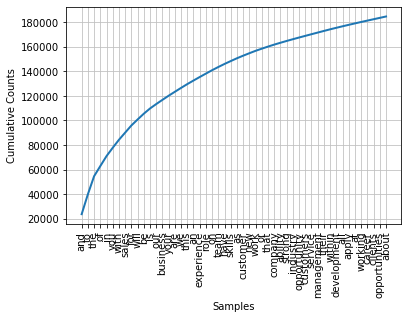

In [14]:
visualise_category_vocab("Sales")

# Data Preprocessing

## Tokenise

In [189]:
# load model that has NER and POS. web_lg not needed as there is no need to use word vectors
nlp = spacy.load('en_core_web_sm')

In [16]:
def make_docs(category=default_category):
    """
    for a given category extract the job descriptions and return a list of 
    documents that have *only* been run through the spacy tokeniser
    """
    data = category_data(category=category)
    docs = [nlp.make_doc(description) for description in data]
    return docs
    
def get_tokenised(document):
    """returns a list of words for a given spacy tokensied document"""
    return [token.text for token in document]

def get_tokenised_docs(documents):
    """
    retunrs a list of token lists for a given collection 
    of spacy tokenised documents
    """
    return [get_tokenised(doc) for doc in documents]

def combine_docs(tokenised_docs):
    """
    returns a single list of tokens for a given list
    of raw tokensied documents
    """
    combined = []
    for doc in tokenised_docs:
        combined.extend(doc)
    return combined

def vocab(docs):
    """returns the vocabluary for a given list of raw job descriptions"""
    return len(FreqDist(combine_docs(get_tokenised_docs(docs))))

def tokenised_vocab(tokenised_docs):
    """returns the vocabulary for a list of already tokensied documents"""
    return len(FreqDist(combine_docs(tokenised_docs)))

In [17]:
docs = make_docs(category="Sales")

In [18]:
vocab(docs)

18446

## Lemmatise vs Stemming

In [19]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [20]:
def morph(words, morphology="lemmatize"):
    """
    Apply a morphological operation to an input list of tokens
    
    Parameters:
        words (List[str]): input words list
        morphology (str): operation to apply to words
    
    Returns:
        list of words with morphological operation applied if applicable
    """
    if(morphology == "lemmatize"):
        return [lemmatizer.lemmatize(word) for word in words]
    elif(morphology == "stem"):
        return [stemmer.stem(word) for word in words]
    else:
        return words
    
def normalise(docs, morphology="lemmatize"):
    """
    applys a morphological operation to all the words in a document for 
    all documents in a given collection
    """
    return [morph(doc, morphology=morphology) for doc in docs]

def spacy_lemmatise(spacy_docs):
    """
    returns a list of documents where each document 
    is a list of spacy lemmatised tokens for the 
    corresponding input document
    """
    return [spacy_lem_doc(doc) for doc in spacy_docs]

def spacy_lem_doc(spacy_doc):
    """returns a list of the lemmatised tokens for a spacy doc"""
    return [token.lemma_ for token in spacy_doc]

In [190]:
def compare_lematise_stemming(category=default_category):
    """
    prints the vocabulary of words in the collection of job descriptions 
    for a given category under different mophological processors. 
    
    List of processors:
    - NLTK WordNetLemmatiser
    - NLTK Porter Stemmer
    - Spacy 'en_core_web_sm' Lemmatiser pipeline
    
    *Warning*: This is a slow function
    """
    docs = make_docs(category=category)
    token_docs = get_tokenised_docs(docs)
    spacy_docs = list(nlp.pipe(docs))
    original = normalise(token_docs, morphology="none")
    lem = normalise(token_docs, morphology="lemmatize")
    stem = normalise(token_docs, morphology="stem")
    spacy_lemmatised_docs = spacy_lemmatise(spacy_docs)
    print(f"Vocabulary of original documents: {tokenised_vocab(original)}")
    print(f"Vocabulary with NLTK lemmatisation: {tokenised_vocab(lem)}")
    print(f"Vocabulary with NLTK Porter stemming: {tokenised_vocab(stem)}")
    print(f"Vocabulary with Spacy lemmatisation: {tokenised_vocab(spacy_lemmatised_docs)}")

In [191]:
compare_lematise_stemming("Sales")

Vocabulary of original documents: 18446
Vocabulary with NLTK lemmatisation: 17264
Vocabulary with NLTK Porter stemming: 10965
Vocabulary with Spacy lemmatisation: 15469


## Retokenisze  

In [233]:
def get_noun_chunks_freqdist(spacy_docs):
    """
    returns a frequency distribution for all the noun
    chunks across a collection of spacy processed input documents
    """
    noun_phrases = []
    for doc in spacy_docs:
        for np in doc.noun_chunks:
            noun_phrases.append(np.text)
    return FreqDist(noun_phrases)

def retokenise_noun_phrases(spacy_docs):
    """
    returns a list of documents that have had their 
    noun chunks merged based on the frequency of the noun
    chunks across the whole corpus of documents
    """
    noun_freqdist = get_noun_chunks_freqdist(spacy_docs)
    for doc in spacy_docs:
        with doc.retokenize() as retokenizer:
            for chunk in doc.noun_chunks:
                # if a phrase occurs more than 3 times retokenise
                if(noun_freqdist[chunk.text] > 3):
                    retokenizer.merge(chunk)
    return spacy_docs

def retokenise_entities(spacy_docs):
    """
    returns a list of documents that have had their 
    entities merged
    """
    for doc in spacy_docs:
        with doc.retokenize() as retokenizer:
            for ent in doc.ents:
                retokenizer.merge(ent)
    return spacy_docs

def retokenise_lemmatise_corpus(category=default_category, report_vocab=False):
    """
    for a given input category 
    
    Parameters:
        category: category to get a document corpus from
        report_vocab: optionaly print out the vocab of preprocessing steps
    
    Comments:
    - Yes I know I run the spacy tokeniser twice with make docs but 
    its negilgable performance for making the code cleaner
    """
    docs = make_docs(category=category)
    spacy_docs = list(nlp.pipe(docs))
    retokenised = retokenise_noun_phrases(spacy_docs)
    lemmatised_docs = spacy_lemmatise(retokenised)
    if(report_vocab):
        print(f"Vocabulary of initial tokenised corpus: {vocab(docs)}")
        print(f"Vocabulary of retokenised and lemmatised documents: {tokenised_vocab(lemmatised_docs)}")
    return lemmatised_docs
    

In [193]:
retokenised_docs = retokenise_lemmatise_corpus(category="Sales", report_vocab=True)

Vocabulary of initial tokenised corpus: 21185
Vocabulary of retokenised corpus: 21185
Vocabulary of retokenised and lemmatised documents: 18050


## Remove stop words

In [ ]:
def genism_bow(docs):
    """
    return a bag of words and associated dictionary for an input collection of documents
    """
    dictionary = Dictionary()
    return [dictionary.doc2bow(doc, allow_update=True) for doc in docs], dictionary

In [197]:
bow, dic = genism_bow(retokenised_docs)

In [199]:
type(dic)

gensim.corpora.dictionary.Dictionary

In [207]:
def tfidf_matrix(bow, dic):
    """
    create the TF-IDF matrix for a bag of words
    
    Parameters:
        bow (List[List[Tuple[Int, Int]]]): genism processed bag of word
        dic (gensim.corpora.dictionary.Dictionary): dictionary for bow
        
    Returns:
        a TF-IDF matrix and the genism tfidf model
    """
    tfidf = TfidfModel(bow, smartirs='ntc')
    vocab = [dic[i] for i in range(len(dic))]
    index = list(range(len(bow)))
    df = pd.DataFrame(data=np.zeros((len(bow), len(vocab)), dtype=np.float16), index=index, columns=vocab)
    for idx in index:
        for id, freq in tfidf[bow[idx]]:
            df[dic[id]][idx] = freq
    return df, tfidf

def join_doc(doc):
    """return a single string of tokens for a given doc"""
    return ' '.join(doc)

def preprocess_descriptions(category=default_category, report_vocab=True):
    """
    Perform initial preprocessing pipeline on the job descriptions for a given category
    
    Parameters:
        category (str): category to perform processing on
        report_vocab (boolean): optionally print the vocab of the resulting processed document collection
        
    Returns:
        a list of strings where each string is a pre-processed job description
    """
    docs = retokenise_lemmatise_corpus(category=category)
    bow, dic = genism_bow(docs)
    tf_df, tfidf = tfidf_matrix(bow, dic)
    newdocs = []
    for doc, tidf in zip(docs, tfidf[bow]):
        newdoc = []
        for (token, (num, val)) in zip(doc, tidf):
            if val >= 0.05:
                newdoc.append(token)
        newdocs.append(newdoc)
    if(report_vocab):
        print(f"Final vocab {tokenised_vocab(newdocs)}")
    return [join_doc(doc) for doc in newdocs], tf_df, tfidf

In [208]:
preproc, fd_df, tfidf, bow = preprocess_descriptions(category="Sales")

Final vocab 8497


In [209]:
fd_df

,,!,&,','s,(,),+,",",-,...,134,Alteryx,StarTrack,askrecruitment@startrack.com.au,disparate,etl,fluency,relatable,shared,sla
0,0.001053,0.015732,0.060852,0.083069,0.045319,0.023758,0.023926,0.023422,0.010567,0.019058,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.001499,0.044830,0.034668,0.000000,0.000000,0.000000,0.000000,0.000000,0.009026,0.005432,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.008369,0.020844,0.016129,0.000000,0.040009,0.000000,0.000000,0.000000,0.006531,0.010101,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.008499,0.000000,0.000000,0.000000,0.000000,0.047943,0.036224,0.000000,0.004265,0.003849,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.027176,0.000000,0.036255,0.000000,0.000000,0.000000,0.000000,0.000000,0.004547,0.003786,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,0.021103,0.000000,0.000000,0.000000,0.025238,0.000000,0.000000,0.000000,0.007061,0.025482,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1460,0.001606,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006447,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1461,0.006355,0.018997,0.029388,0.000000,0.000000,0.000000,0.000000,0.000000,0.007225,0.013809,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1462,0.002302,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003851,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [272]:
def sort_cumulative(x):
    """
    Sort a dictionary x = {k:v} by its value in reverse order
    """
    return {k: v for k, v in sorted(x.items(), key=lambda item: item[1], reverse=True)}

def get_cumulative_tfidf(docs):
    """
    get the cumulative TFIDF score of a token across all documents in a collection
    """
    cumulative_noun_tfidf = {}
    cumulative_entity_tfidf = {}
    spacy_docs = list(nlp.pipe(docs))
    noun_retokenised = retokenise_noun_phrases(spacy_docs)
    entity_retokensied = retokenise_entities(spacy_docs)
    for ndoc, edoc, tidf in zip(noun_retokenised, entity_retokensied, tfidf[bow]):
            noun_chunks = set([token.text for token in list(ndoc.noun_chunks)])
            entities = set([token.text for token in list(edoc.ents)])
            for (ntoken, etoken, (num, val)) in zip(ndoc, edoc, tidf):
                if ntoken.text in noun_chunks:
                    if ntoken.text not in cumulative_noun_tfidf:
                        cumulative_noun_tfidf[ntoken] = val
                    else:
                        cumulative_noun_tfidf[ntoken] += val
                if etoken.text in entities:
                    if etoken  not in cumulative_entity_tfidf:
                        cumulative_entity_tfidf[etoken] = val
                    else:
                        cumulative_entity_tfidf[etoken] += val
    return sort_cumulative(cumulative_noun_tfidf), sort_cumulative(cumulative_entity_tfidf)

## Generate Chatbot output

In [311]:
def process_all_categories():
    """process all data in all categories"""
    category_corpus = {}

    for category in df["category"].unique():  
        preproc, fd_df, tfidf, bow = preprocess_descriptions(category=category, report_vocab=False)
        noun_chunks, entities = get_cumulative_tfidf(preproc)
        category_corpus[category] = {
            "preproc": preproc,
            "fd_df": fd_df,
            "tfidf" : tfidf,
            "bow" :bow,
            "noun_cunks": noun_chunks,
            "entities": entities
        }
    return category_corpus

def dump_json_output():
    """dump the output json object"""
    #job names, locations, company names, areas of experience
    lists = ["job_title", "city", "company_name", "job_type"]
    output = {
        "job_title": {},
        "city": {},
        "company_name": {},
        "job_type": {}
    }
    other = ["experience"]
    for attribute in lists[1:2]:
        for val in df[attribute].unique():
            ndf = df[df[attribute] == val]
            for category in category_corpus:
                ne_chunks = list(category_corpus[str(category)]["noun_cunks"])[0:100]+list(category_corpus[str(category)]["entities"])[0:100]
                output[attribute][val] = {
                    "category": str(category),
                     #get processed job description summary
#                     "description summary": str(category_corpus[category]["preproc"]),
                    # select top 100 entities and noun chunks to match against
                    "noun_entity_chunks": str(ne_chunks)
                }
    with open("data.json", "w") as outfile:
        json.dump(output, outfile)

In [ ]:
dump_json_output()

# Linguistic Patterns

In [92]:
def dis_render(docs, style='dep'):
    "displays a collection of documents with displacy"
    for doc in docs:
            displacy.render(doc, style=style)
             
def check_starters(starters, entity, patterns, n=10, render=False):
    """
    prints the matches for a given set of patterns on a generated set of inputs
    
    """
    examples = []
    for starter in starters:
        for attribute in df[entity].head(n).unique():
            examples.append(starter.replace("SUB", attribute).replace("&", "and"))
    docs = list(nlp.pipe(examples))
    print(render)
    return check_matches(docs, patterns, render=render)

def check_examples(examples, patterns, render=False):
    docs = list(nlp.pipe(examples))
    return check_matches(docs, patterns, render=render)
            
def check_matches(docs, patterns, render=False):
    if render:
        dis_render(docs)
    matcher = Matcher(nlp.vocab)
    matcher.add("patterns", patterns)
    match_docs = [matcher(doc) for doc in docs]
    for i, doc in enumerate(docs):
        print(doc)
        matches = match_docs[i]
        for match_id, start, end in matches:
            span = doc[start:end]
            print("Span: ", span.text)
        print()
    return docs

## Category and Job Name

In [96]:
category_starters = [
    "find me a job in SUB",
    "get me a job in SUB",
    "looking for a SUB job",
    "anything in SUB",
    "I am looking for a SUB job",
    "I am looking for something in SUB"
]

category_examples = [
    "I am looking for a job in Services in Brisbane",
    "I am looking for an Accounting job "
]

In [117]:
category_1 = [ 
        {"LOWER": "job"},
        {"DEP": "prep"},
        {"DEP": "pobj"},
        {"DEP": "cc", "OP":"?"},
        {"DEP": "conj", "OP":"?"}
]
category_2 = [
        {"LOWER": "job"},
        {"DEP": "prep"},
        {"POS": "PROPN"},
        {"DEP": "cc", "OP":"?"},
        {"DEP": "conj", "OP":"?"},
        {"DEP": "pobj", "OP":"?"},
]
category_3 = [
    {"POS": "ADP"},
    {"DEP": "pobj", "POS": "PROPN"},
    {"DEP": "cc", "OP":"?"},
    {"DEP": "conj", "OP":"?"},
    {"DEP": "pobj", "OP":"?"},
]

category_example_1 = [
    {"DEP": "pobj", "POS":"NOUN"},
    {"DEP": "prep"},
    {"DEP": "pobj", "POS": "PROPN"}
]

category_example_2 = [
    {"DEP": "det"},
    {"DEP": "compound"},
    {"POS": "NOUN"}
]

In [118]:
# check_starters(category_starters, "category", [category_1, category_2, category_3], n=len(df))

In [120]:
ds = check_examples(category_examples, [category_example_1, category_example_2])

I am looking for a job in Services in Brisbane
Span:  job in Services

I am looking for an Accounting job 
Span:  an Accounting job



## Location

In [140]:
location_starters = [
    "looking for a job located in SUB",
    "around the SUB area",
    "around SUB",
    "near SUB"
]

location_1 = [
    {"DEP": "ROOT"},
    {"DEP": "det"},
    {"DEP": "nmod"}
]
location_2 = [
    {"DEP": "ROOT"},
    {"DEP": "pobj"}
]

location_examples = [
    "Are there any Enginnering jobs available in Brisbane",
    "What Retail assistant jobs are there in Perth"
]

location_example_1 = [
    {"DEP": "amod"},
    {"DEP": "prep"},
    {"ENT_TYPE": "GPE"}
    
]

location_example_2 = [
    {"POS": "AUX"},
    {"DEP": "advmod"},
    {"DEP": "prep"},
    {"DEP": "pobj"}
]
ds = check_examples(location_examples, [location_example_1, location_example_2])

Are there any Enginnering jobs available in Brisbane
Span:  available in Brisbane

What Retail assistant jobs are there in Perth
Span:  are there in Perth



## Company Name

In [147]:
company_starters = [
    "I would like to work for SUB",
    "Ideally I would work for SUB",
    "I want to work at SUB",
    "My dream job would be at SUB"
]

company_examples = [
    "Is Microsoft currently hiring Software Engineers in Melbourne",
    "I would like an Insurance job preferably with HBF"
]

company_example_1 = [
    {"DEP": "aux"},
    {"DEP": "nsubj", "ENT_TYPE": "ORG"},
]

company_example_2 = [
    {"POS": "ADP"},
    {"DEP": "pobj", "ENT_TYPE": "ORG"},
]
ds = check_examples(company_examples, [company_example_1, company_example_2])

Is Microsoft currently hiring Software Engineers in Melbourne
Span:  Is Microsoft

I would like an Insurance job preferably with HBF
Span:  with HBF



In [144]:
dis_render(ds, style='ent')

## Job Type

In [161]:
job_starters = [
    "I would be SUB",
    "I want to work SUB",
]

job_type_examples = [
    "What jobs in Perth are there offer fulltime employment",
    "Can you find me a job that is part time, located in Adelaid and has a decent salary"
]
job_type_example_1 = [
    {"POS": "VERB"},
    {"DEP": "amod"},
    {"DEP": "dobj", "OP" : "?"}
]

job_type_example_2 = [
    {"POS": "AUX", "OP": "?"},
    {"DEP": "compound"},
    {"DEP": "attr"},
]
ds = check_examples(job_type_examples, [job_type_example_1, job_type_example_2])

What jobs in Perth are there offer fulltime employment
Span:  offer fulltime
Span:  offer fulltime employment

Can you find me a job that is part time, located in Adelaid and has a decent salary
Span:  is part time
Span:  part time



## Experience

In [178]:
experience_examples = [
    "I have little experience but is there anything in Government and defence that might fit",
    "I am looking for a job as a very experienced tradesman",
    "Are there any jobs with no experience requirements"
]

experience_example_1 = [
    {"POS": "VERB"},
    {"DEP": "amod", "OP": "?"},
    {"DEP": "dobj"},
]

experience_example_2 = [
    {"POS": "ADV", "OP": "?"},
    {"DEP": "advmod", "OP": "?"},
    {"DEP": "amod"},
    {"POS": "NOUN"}
]

experience_example_3 = [
    {"DEP": "det"},
    {"DEP": "compound"}
]
ds = check_examples(experience_examples, [experience_example_1, experience_example_2, experience_example_3])

I have little experience but is there anything in Government and defence that might fit
Span:  little experience
Span:  have little experience

I am looking for a job as a very experienced tradesman
Span:  very experienced tradesman
Span:  experienced tradesman

Are there any jobs with no experience requirements
Span:  no experience



# Additional Research

note please dont run the cells below as it will wreck the formatting

Often users will struggle to provide all the information needed for an accurate response in one turn of dialog interation [1]. This can be due to a number of factors suchas not being able to remember everything or not knowing what information is required for the best quality response. One way to handle multi-turn dialog interactions is a Finite-state Machine (FSM). A FSM is an abststract model of computation whereby the machine can in exactly one of a finite number of states at any given time and transitions between them in response to some input [2]. In the context of a chatbot a state machine could be an encoding of entities which need to be extracted in order to return a result. For example consider the following simplified 
FSM for extracting a job description:


   V------------------------ no                      
input -> location in name                  v-------------------------no
                          yes -> ask for job name -> job name found
                                                                     yes -> extract job description and return to user
           
This type of FSM was investigated for this project (see the starters objects in the linguistic patterns section) whereby each relevant entity would need to be extracted before giving an anser. An alternative idea would be to encode expected dialog interactions as entity relations. Consider the following example used to train the Watson assistant [3]:

entities = { 
"user input": "response"
"knock knock": "Who is there"
}
user: knock knock
     bot: who is there
        user: answer <- extract answer to question here
 
However having manual encodings for dialog interactions is infeasable or would require substantial processing to achieve. Alternatively dedicated models could be trained on large datasets to recognise multi-turn dialog (for example twitter threads or reddit posts). Baudart et. al. investigated this idea creating what they termed a "Thread-Encoder" neural network which addresses the problem of multi-turn response selection by encoding extracted dialog histories (examples of conversations) and training a matcher output the correct response for a given dialog history [4]. For the task of a job search chat bot, if sufficient user utterances and interactions could be recorded into a dataset a similar model could be trained and allow a chatbot to have better responses to job search queries. 

### References

[1] Zamanirad, S., Benatallah, B., Rodriguez, C., Yaghoubzadehfard, M., Bouguelia, S., & Brabra, H. (2020, June). State machine based human-bot conversation model and services. In International Conference on Advanced Information Systems Engineering (pp. 199-214). Springer, Cham.

[2] Sakarovitch, J. (2009). Elements of automata theory. Cambridge University Press.

[3] Baudart, G., Hirzel, M., Mandel, L., Shinnar, A., & Siméon, J. (2018, November). Reactive chatbot programming. In Proceedings of the 5th ACM SIGPLAN International Workshop on Reactive and Event-Based Languages and Systems (pp. 21-30).

[4] Jia, Q., Liu, Y., Ren, S., Zhu, K. Q., & Tang, H. (2020). Multi-turn response selection using dialogue dependency relations. arXiv preprint arXiv:2010.01502. 

